In [1]:
from PIL import Image # (pip install Pillow)
import numpy as np                                 # (pip install numpy)
from skimage import measure                        # (pip install scikit-image)
from shapely.geometry import Polygon, MultiPolygon # (pip install Shapely)
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import json
from skimage.morphology import skeletonize, medial_axis
from label_centerlines import get_centerline
from skimage import img_as_bool

In [3]:
import os

In [7]:
dest_root = os.path.join('..', 'inference', 'targets')
dest_img_dir = os.path.join(dest_root, 'jpegs')
dest_png_dir = os.path.join(dest_root, 'pngs')
dest_gt_dir = os.path.join(dest_root, 'transformed')

In [25]:
jpeg_imgs = sorted(os.listdir(dest_img_dir))
png_imgs = sorted(os.listdir(dest_png_dir))
gt_imgs =  sorted(os.listdir(dest_gt_dir))

In [37]:
img = Image.open(os.path.join(dest_img_dir, jpeg_imgs[3])) # np.array(Image.open(os.path.join(dest_img_dir, jpeg_imgs[0])))
mask_img = Image.open(os.path.join(dest_gt_dir, gt_imgs[3])) # np.array(Image.open(os.path.join(dest_gt_dir, gt_imgs[0])))

In [46]:
def drawPolygon(polygon, color_image):
    # print(isinstance(polygon, MultiPolygon))
    if type(polygon) == MultiPolygon:
        print('multi')
        for polyg in polygon:
            x,y = polyg.exterior.xy
            plt.imshow(color_image)
            plt.plot(x,y, linewidth=10)
    else:
        x,y = polygon.exterior.xy
        plt.imshow(color_image)
        plt.plot(x,y, linewidth=10)

In [38]:
def create_sub_masks(mask_image):
    width, height = mask_image.size

    area = width * height
    # Initialize a dictionary of sub-masks indexed by RGB colors
    sub_masks = {}
    for x in range(width):
        for y in range(height):
            # Get the RGB values of the pixel
            pixel = mask_image.getpixel((x,y)) #[:3]

            # If the pixel is not black...
            if pixel != 0:
                # Check to see if we've created a sub-mask...
                pixel_str = str(pixel)
                sub_mask = sub_masks.get(pixel_str)
                if sub_mask is None:
                    # Create a sub-mask (one bit per pixel) and add to the dictionary
                    # Note: we add 1 pixel of padding in each direction
                    # because the contours module doesn't handle cases
                    # where pixels bleed to the edge of the image
                    sub_masks[pixel_str] = Image.new('1', (width+2, height+2))

                # Set the pixel value to 1 (default is 0), accounting for padding
                sub_masks[pixel_str].putpixel((x+1, y+1), 1)

    return sub_masks, area

In [68]:
def create_sub_mask_annotation(sub_mask, color_image, image_id, category_id, annotation_id, is_crowd, image_area, 
                               filter_ratio=0.03, init_buffer=0):
    
    img_width = sub_mask.width
    img_height = sub_mask.height
    print(img_width, img_height)
    
    # Find contours (boundary lines) around each sub-mask
    # Note: there could be multiple contours if the object
    # is partially occluded. (E.g. an elephant behind a tree)
    contours = measure.find_contours(np.array(sub_mask), 0.5, positive_orientation='low')

    # To make polygons broken
    def create_multi_polygons(polygon, bufferNum):
        threshold = 0.01
        buffered_polygon = polygon.buffer(bufferNum)
        if (type(buffered_polygon) == MultiPolygon):
            result = []
            for b_polygon in buffered_polygon:
                if b_polygon.area / image_area < threshold :
                    result.append(b_polygon)
                else:
                    result += create_multi_polygons(polygon, bufferNum-1)
            return result
        elif (type(buffered_polygon) == Polygon):
            if buffered_polygon.area / image_area < threshold :
                return [buffered_polygon]
            else :
                return create_multi_polygons(buffered_polygon, bufferNum-1)
            
    
    segmentations = []
    polygons = []
    for contour in contours:
        # Flip from (row, col) representation to (x, y)
        # and subtract the padding pixel
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # Make a polygon and simplify it
        poly = Polygon(contour)
        poly = poly.simplify(1.0, preserve_topology=False)
        polygons.append(poly)

        segmentation = np.array(poly.exterior.coords).ravel().tolist()
        segmentations.append(segmentation)

    # Combine the polygons to calculate the bounding box and area
    multi_poly = MultiPolygon(polygons)
    annotations = []
    fig = plt.figure()
    fig.set_size_inches(12, 27)
    for i, polygon in enumerate(multi_poly):
        area = polygon.area 
        ratio = area / image_area
        if ratio > filter_ratio : 
            buffered_polygons = create_multi_polygons(polygon, init_buffer)
            centroids = []
            for polyg in buffered_polygons:
                polyg = polyg.simplify(0.1, preserve_topology=False)
                if polyg.area == 0.0:
                    continue
                centroids.append(polyg.centroid.xy)
                drawPolygon(polyg, color_image)
            positions = []
            for ii in centroids:
                positions.append([ii[0][0], ii[1][0]])
                
            drawPolygon(polygon, color_image)

    return annotations

In [64]:
# coarcion 로 line 잇고 .. 하는 알고리즘
def create_sub_mask_annotation(sub_mask, color_image, image_id, category_id, annotation_id, is_crowd, image_area, 
                               filter_ratio=0.03, init_buffer=0):
    
    img_width = sub_mask.width
    img_height = sub_mask.height
    print(img_width, img_height)
    
    # Find contours (boundary lines) around each sub-mask
    # Note: there could be multiple contours if the object
    # is partially occluded. (E.g. an elephant behind a tree)
    contours = measure.find_contours(np.array(sub_mask), 0.5, positive_orientation='low')

    # To make polygons broken
    def create_multi_polygons(polygon, bufferNum):
        threshold = 0.01
        buffered_polygon = polygon.buffer(bufferNum)
        if (type(buffered_polygon) == MultiPolygon):
            result = []
            for b_polygon in buffered_polygon:
                if b_polygon.area / image_area < threshold :
                    result.append(b_polygon)
                else:
                    result += create_multi_polygons(polygon, bufferNum-1)
            return result
        elif (type(buffered_polygon) == Polygon):
            if buffered_polygon.area / image_area < threshold :
                return [buffered_polygon]
            else :
                return create_multi_polygons(buffered_polygon, bufferNum-1)
            
    
    segmentations = []
    polygons = []
    for contour in contours:
        # Flip from (row, col) representation to (x, y)
        # and subtract the padding pixel
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # Make a polygon and simplify it
        poly = Polygon(contour)
        poly = poly.simplify(1.0, preserve_topology=False)
        polygons.append(poly)

        segmentation = np.array(poly.exterior.coords).ravel().tolist()
        segmentations.append(segmentation)

    # Combine the polygons to calculate the bounding box and area
    multi_poly = MultiPolygon(polygons)
    annotations = []
    fig = plt.figure()
    fig.set_size_inches(12, 27)
    for i, polygon in enumerate(multi_poly):
        area = polygon.area 
        ratio = area / image_area
        if ratio > filter_ratio : 
            buffered_polygons = create_multi_polygons(polygon, init_buffer)
            centroids = []
            for polyg in buffered_polygons:
                polyg = polyg.simplify(0.1, preserve_topology=False)
                if polyg.area == 0.0:
                    continue
                centroids.append(polyg.centroid.xy)
                drawPolygon(polyg, color_image)
            positions = []
            for ii in centroids:
                positions.append([ii[0][0], ii[1][0]])
                
            drawPolygon(polygon, color_image)

            splitPolygon = polygon.simplify(1.0, preserve_topology=False)
            
            min_x, min_y, max_x, max_y = splitPolygon.bounds
            width = max_x - min_x
            height = max_y - min_y
            bbox = (max_x, max_y, min_x, min_y) # detectron2 style
            area = splitPolygon.area

            segmentation = np.array(splitPolygon.exterior.coords).ravel().tolist()
            annotation = {
                'segmentation': [segmentation],
                'iscrowd': is_crowd,
                'image_id': image_id,
                'category_id': category_id,
                'id': annotation_id,
                'bbox': bbox, #(50,50,100,100)
                'area': area
            }

            annotations.append(annotation)

    return annotations

In [77]:
# skeletonize
def create_sub_mask_annotation(sub_mask, color_image, image_id, category_id, annotation_id, is_crowd, image_area, 
                               filter_ratio=0.03, init_buffer=0):
    BLUE = '#6699cc'
    GRAY = '#999999'
    DARKGRAY = '#333333'
    YELLOW = '#ffcc33'
    GREEN = '#339933'
    RED = '#ff3333'
    BLACK = '#000000'
    
    img_width = sub_mask.width
    img_height = sub_mask.height
    print(img_width, img_height)
    
    # Find contours (boundary lines) around each sub-mask
    # Note: there could be multiple contours if the object
    # is partially occluded. (E.g. an elephant behind a tree)
    contours = measure.find_contours(np.array(sub_mask), 0.5, positive_orientation='low')
    
    
    #######################################
    #######################################
    #######################################
    #######################################
    ###############skeletonize#############
    #######################################
    #######################################
    #######################################
    #######################################
    
    # out = medial_axis(img_as_bool(sub_mask))
    out = skeletonize(img_as_bool(sub_mask), method='lee')

    f, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 32))
    ax0.imshow(sub_mask, cmap='gray', interpolation='nearest')
    ax1.imshow(out, cmap='gray', interpolation='nearest')
    plt.show()
    # To make polygons broken
    def create_multi_polygons(polygon, bufferNum):
        threshold = 0.01
        buffered_polygon = polygon.buffer(bufferNum)
        if (type(buffered_polygon) == MultiPolygon):
            result = []
            for b_polygon in buffered_polygon:
                if b_polygon.area / image_area < threshold :
                    result.append(b_polygon)
                else:
                    result += create_multi_polygons(polygon, bufferNum-1)
            return result
        elif (type(buffered_polygon) == Polygon):
            if buffered_polygon.area / image_area < threshold :
                return [buffered_polygon]
            else :
                return create_multi_polygons(buffered_polygon, bufferNum-1)
    def color_issimple(ob, simple=BLUE, complex=YELLOW):
        if ob.is_simple:
            return simple
        else:
            return complex


    def plot_line(ob, color=GRAY, zorder=1, linewidth=3, alpha=1):
        x, y = ob.xy
        plt.plot(x, y, color=color, linewidth=linewidth, solid_capstyle='round', zorder=zorder, alpha=alpha)

    def plot_line_issimple(ob, **kwargs):
        kwargs["color"] = color_issimple(ob)
        plot_line(ob, **kwargs)           
    
    segmentations = []
    polygons = []
    for contour in contours:
        # Flip from (row, col) representation to (x, y)
        # and subtract the padding pixel
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # Make a polygon and simplify it
        poly = Polygon(contour)
        poly = poly.simplify(1.0, preserve_topology=False)
        polygons.append(poly)

        segmentation = np.array(poly.exterior.coords).ravel().tolist()
        segmentations.append(segmentation)

    # Combine the polygons to calculate the bounding box and area
    multi_poly = MultiPolygon(polygons)
    annotations = []
    fig = plt.figure()
    fig.set_size_inches(12, 27)
    for i, polygon in enumerate(multi_poly):
        area = polygon.area 
        ratio = area / image_area
        if ratio > filter_ratio : 
#             buffered_polygons = create_multi_polygons(polygon, init_buffer)
#             centroids = []
#             for polyg in buffered_polygons:
#                 polyg = polyg.simplify(0.1, preserve_topology=False)
#                 if polyg.area == 0.0:
#                     continue
#                 centroids.append(polyg.centroid.xy)
#                 drawPolygon(polyg, color_image)
#             positions = []
#             for ii in centroids:
#                 positions.append([ii[0][0], ii[1][0]])
                
#             drawPolygon(polygon, color_image)

            splitPolygon = polygon.simplify(1.0, preserve_topology=False)
        
            #######################################
            #######################################
            #######################################
            #######################################
            ##################center###############
            #######################################
            #######################################
            #######################################
            #######################################
            out = get_centerline(splitPolygon)
            drawPolygon(splitPolygon, color_image)
            plot_line_issimple(out)

            min_x, min_y, max_x, max_y = splitPolygon.bounds
            width = max_x - min_x
            height = max_y - min_y
            bbox = (max_x, max_y, min_x, min_y) # detectron2 style
            area = splitPolygon.area

            segmentation = np.array(splitPolygon.exterior.coords).ravel().tolist()
            annotation = {
                'segmentation': [segmentation],
                'iscrowd': is_crowd,
                'image_id': image_id,
                'category_id': category_id,
                'id': annotation_id,
                'bbox': bbox, #(50,50,100,100)
                'area': area
            }

            annotations.append(annotation)

    return annotations

In [78]:
def test(img, mask_img):
    sub_masks, area = create_sub_masks(mask_img)
    annotation = create_sub_mask_annotation(sub_masks['1'], img, 125, 1, 1, 
                                            0, area, 0.03, 0)

211 211


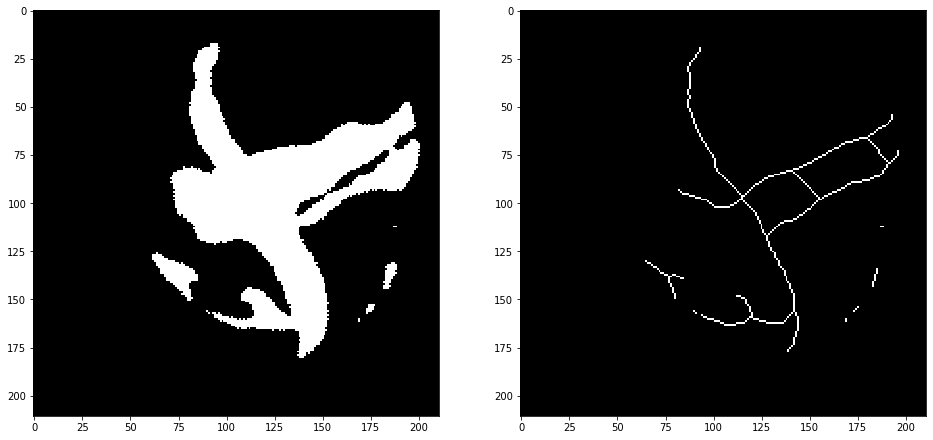

201 201


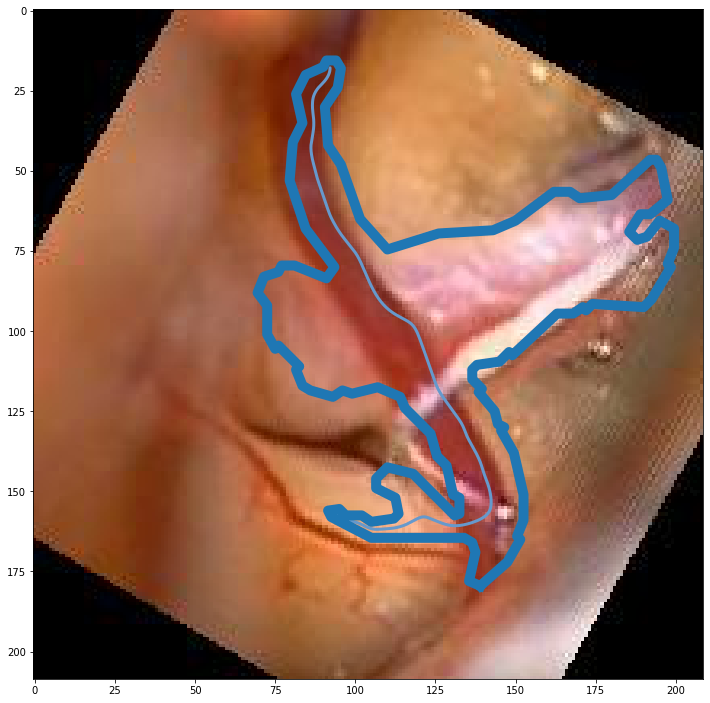

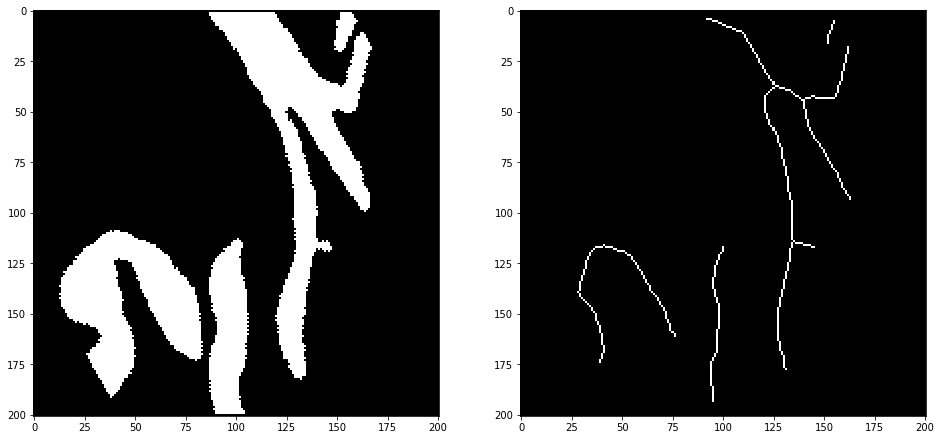

177 177


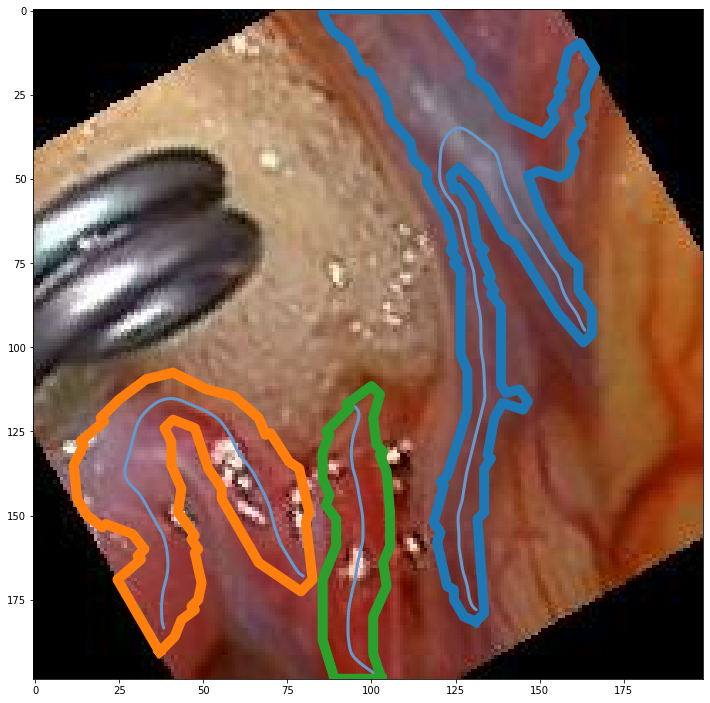

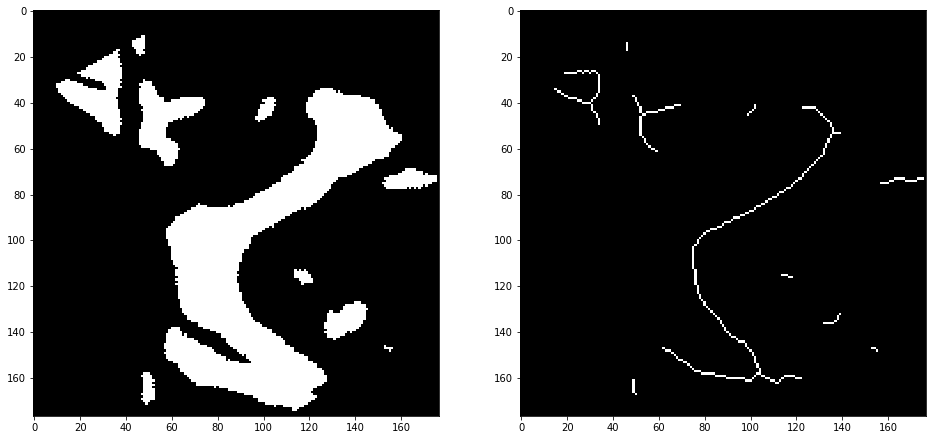

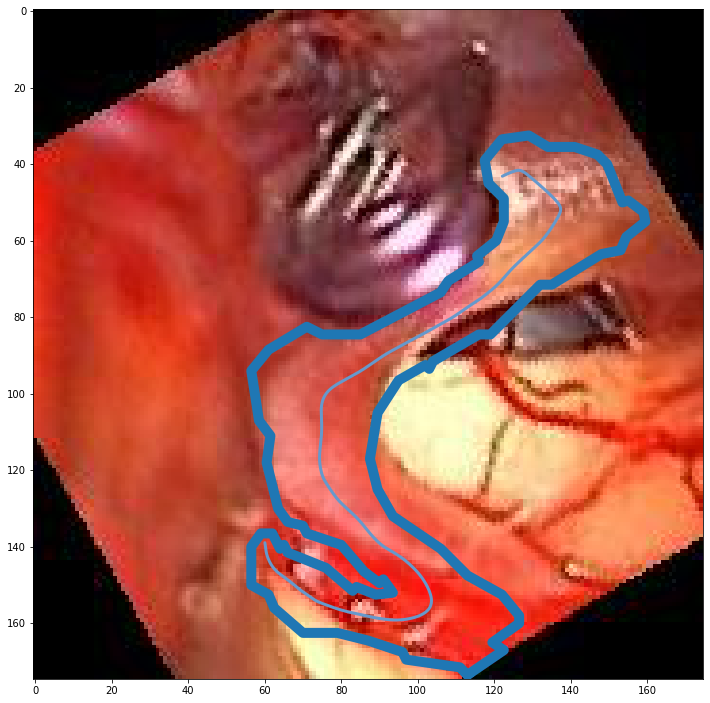

In [80]:
for img_name, mask_name in zip(jpeg_imgs[:3], gt_imgs[:3]):
    img = Image.open(os.path.join(dest_img_dir, img_name))
    mask_img = Image.open(os.path.join(dest_gt_dir, mask_name))
    test(img, mask_img)